# Run Objective:

### Run0164


-  Fixing mission critical bug.
-  `Theta_branch` (calculates threshold aka c_2) uses a `activation=tanh` instead of `activation=linear`.
-  Uses `Run0161f` as a base model (`L2 = 5E-7` instead of the more usual `L2 = 5E-5`).

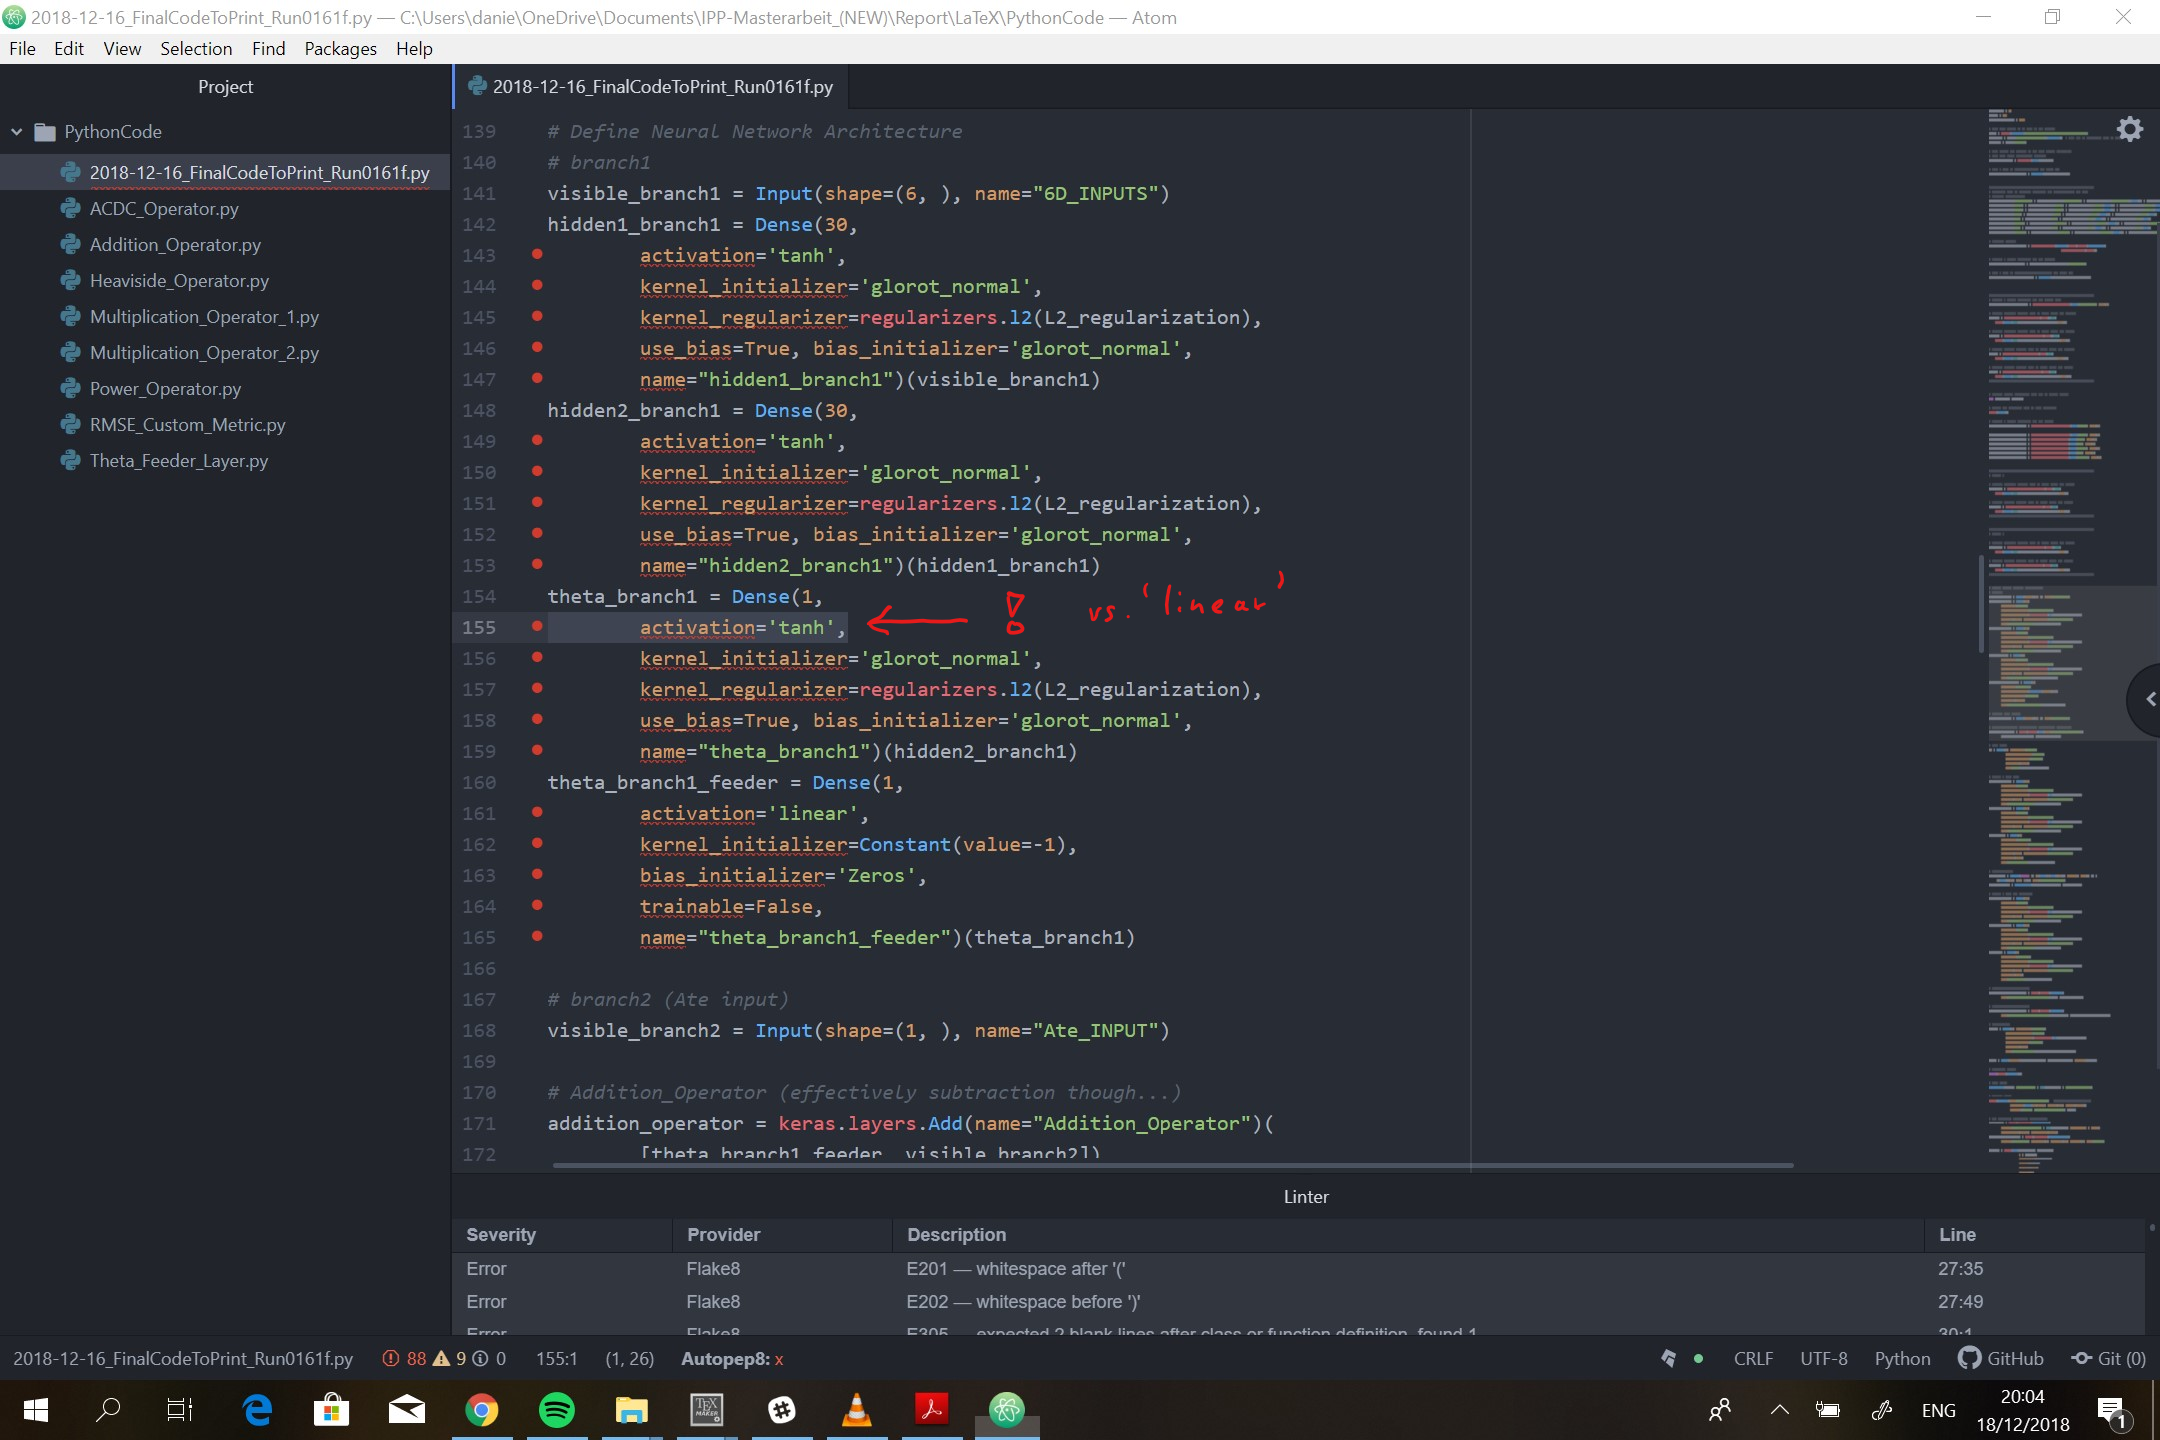

In [ ]:
# DO NOT RUN THIS PART

In [ ]:
import os
import sys
import time

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])
print(file_name)

if file_name == "ipykernel_launcher":
    print("This is the Jupyter version.")
    print("Now MANUALLY run the next two cells!")
    print("STOP! This should not be in your code!!")
    exit(0)
    time.sleep(10)
    print("Testing if script has really stopped.")
else:
    print("This is the Atom version")

In [1]:
# RUN ONLY IN JUPYTER!!
# Start here (manual)

In [2]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"');

<IPython.core.display.Javascript object>

In [3]:
print(file_name)

2018-12-18_Run0164.ipynb


In [4]:
file_name = file_name[:-6]
print(file_name)

is_Jupyter = True
print(is_Jupyter)

2018-12-18_Run0164
True


In [5]:
# Same code for both ATOM & JUPYTER from now (Run all cells below now)

In [6]:
'''
Late Fusion Module (test) - Functional API
'''

# Multiple Inputs
import keras
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal, glorot_normal, Constant
from keras.utils import plot_model
from keras.models import Model
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers import Dense
from keras.layers import MaxoutDense
from keras.layers.merge import concatenate
from keras import regularizers
from keras import backend as K
#from keras.backend import switch
import pandas
import numpy
import sys
import os
from copy import deepcopy
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers.advanced_activations import ThresholdedReLU

#keras.backend.clear_session()
K.clear_session()

Using TensorFlow backend.


In [7]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

In [8]:
# Modify for ATOM use

In [9]:
if is_Jupyter == True:
    pass
else:
    # Gets the current file name. Useful for procedurally generating output/log files.
    file_name =  os.path.basename(sys.argv[0][:-3])

In [10]:
# Define neural network parameters
batch_size = 10
epochs = 100
L2_regularization = 5E-7

In [11]:
# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("training_gen3_7D_nions0_flat_filter8.h5")
target_df = store['/output/efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']

# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for later use
joined_dataFrame_original = deepcopy(joined_dataFrame)


# *************************************************************************** #
# Normalize data by standard deviation and mean-centering the data
# Standard configuration
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean()) / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['q'] = (joined_dataFrame['q'] - joined_dataFrame['q'].mean()) / joined_dataFrame['q'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Make a copy of shuffled_joined_dataFrame for later use
shuffled_joined_dataFrame_base = deepcopy(shuffled_joined_dataFrame)



# *************************************************************************** #
# Creates a pandas dataframe for the inputs (7D)
shuffled_clean_input_df_7D = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df_7D.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df_7D.iloc[int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9)):]
# *************************************************************************** #


# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()


In [12]:
shuffled_clean_input_df_7D.describe(include='all')

,Ati,Ate,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,-1.408115e-16,2.631859e-16,2.264784e-16,8.721538e-17,-1.757731e-17,-7.194107e-19,5.187214e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.639065e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-7.898708e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,-9.507533e-02,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,5.997202e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,2.684107e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [13]:
# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_1 = shuffled_clean_input_df_7D.drop('Ate', axis=1)

In [14]:
shuffled_clean_input_df_1.describe(include='all')

,Ati,An,q,smag,x,Ti_Te
count,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06,6.479137e+06
mean,-1.408115e-16,2.264784e-16,8.721538e-17,-1.757731e-17,-7.194107e-19,5.187214e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.632300e+00,-1.901001e+00,-8.370116e-01,-1.574307e+00,-1.405340e+00,-1.235044e+00
25%,-7.928000e-01,-5.438138e-01,-6.367600e-01,-8.011463e-01,-9.907529e-01,-8.817246e-01
50%,-1.059360e-01,1.347799e-01,-3.983652e-01,-1.936629e-01,-1.615792e-01,-1.750863e-01
75%,5.809279e-01,6.437252e-01,1.976217e-01,9.108525e-01,6.675945e-01,7.576761e-01
max,2.641520e+00,1.831264e+00,2.581570e+00,1.739239e+00,1.704062e+00,1.944828e+00


In [15]:
print(shuffled_clean_input_df_1.shape)

(6479137, 6)


In [16]:
shuffled_clean_input_df_2 = shuffled_clean_input_df_7D.drop('Ati', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('An', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('q', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('smag', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('x', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('Ti_Te', axis=1)

In [17]:
shuffled_clean_input_df_2.describe(include='all')

,Ate
count,6.479137e+06
mean,2.631859e-16
std,1.000000e+00
min,-1.639065e+00
25%,-7.898708e-01
50%,-9.507533e-02
75%,5.997202e-01
max,2.684107e+00


In [18]:
print(shuffled_clean_input_df_2.shape)

(6479137, 1)


In [19]:
# *************************************************************************** #
# Branch 1

# Creates training dataset (90% of total data) for inputs
x_train_1 = shuffled_clean_input_df_1.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_1 = shuffled_clean_input_df_1.iloc[int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9)):]
# *************************************************************************** #

In [20]:
# *************************************************************************** #
# Branch 2

# Creates training dataset (90% of total data) for inputs
x_train_2 = shuffled_clean_input_df_2.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_2 = shuffled_clean_input_df_2.iloc[int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9)):]
# *************************************************************************** #

In [21]:
# branch1
visible_branch1 = Input(shape=(6, ), name="6D_INPUTS")
hidden1_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch1")(visible_branch1)
hidden2_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch1")(hidden1_branch1)
theta_branch1 = Dense(1,
        activation='linear',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="theta_branch1")(hidden2_branch1)
theta_branch1_feeder = Dense(1,
        activation='linear',
        kernel_initializer=Constant(value=-1),
        bias_initializer='Zeros',
        trainable=False,
        name="theta_branch1_feeder")(theta_branch1)

# branch2 (Ate input)
visible_branch2 = Input(shape=(1, ), name="Ate_INPUT")

# Addition_Operator (effectively subtraction though...)
addition_operator = keras.layers.Add(name="Addition_Operator")([theta_branch1_feeder, visible_branch2])

# ReLU Layer
TR = Dense(1, activation='relu',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=False,
           name="TR")(addition_operator)

# branch 3 (for c_3)
hidden1_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch3")(visible_branch1)
hidden2_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch3")(hidden1_branch3)
c_3_branch3 = Dense(1,
        activation='linear',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        trainable=True,
        name="c_3_branch3")(hidden2_branch3)

# Power_Operator    
power_layer = Lambda(lambda x: (K.clip(K.abs(x[0]), 0.00001, 1000)) ** (K.clip(x[1], -2., 4.)), name="Power_Operator")
power_operator = power_layer([addition_operator, c_3_branch3])

# branch 4 (for the gradient)
hidden1_branch4 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch4")(visible_branch1)
hidden2_branch4 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch4")(hidden1_branch4)
m_branch4 = Dense(1,
        activation='linear',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(L2_regularization),
        use_bias=True, bias_initializer='glorot_normal',
        trainable=True,
        name="m_branch4")(hidden2_branch4)   

# Multiplication_Operator_1
multiplication_operator_1 = keras.layers.Multiply(name="Multiplication_Operator_1")([TR, power_operator])

# Multiplication_Operator_2
multiplication_operator_2 = keras.layers.Multiply(name="Multiplication_Operator_2")([m_branch4, multiplication_operator_1])

# Output_Layer
output = Dense(1, activation='linear',
           kernel_initializer='Ones',
           kernel_regularizer=regularizers.l2(L2_regularization),
           bias_initializer='Zeros',
           trainable=True,
           name="Output_Layer")(multiplication_operator_2)

model = Model(inputs=[visible_branch1, visible_branch2], outputs=output)

# summarize layers
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
6D_INPUTS (InputLayer)          (None, 6)            0                                            
__________________________________________________________________________________________________
hidden1_branch1 (Dense)         (None, 30)           210         6D_INPUTS[0][0]                  
__________________________________________________________________________________________________
hidden2_branch1 (Dense)         (None, 30)           930         hidden1_branch1[0][0]            
__________________________________________________________________________________________________
theta_branch1 (Dense)           (None, 1)            31          hidden2_branch1[0][0]            
__________________________________________________________________________________________________
hidden1_br

In [22]:
# plot graph
plot_model(model, 'ModelPlots/' + str(file_name) + '_model_plot.png')

In [23]:
model.compile(loss='mean_squared_error',   #categorical_crossentropy
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["mae", "mean_squared_error", rmse])

# Add CallBacks (including TensorBoard)
tbCallBack = keras.callbacks.TensorBoard(
        log_dir='TensorBoard_logs/' + str(file_name), write_graph = False, write_images=False, write_grads=False)
EarlyStoppingCallBack = keras.callbacks.EarlyStopping(
        monitor='val_rmse', min_delta=0, patience=15, verbose=0, mode='auto')

history = model.fit([x_train_1, x_train_2],
                    y = y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=2,
                    # validation_data=(x_test, y_test),
                    validation_data=([x_test_1, x_test_2], y_test),
                    #callbacks=[tbCallBack, EarlyStoppingCallBack, NBatchLogger(5e4)])
                    callbacks=[tbCallBack, EarlyStoppingCallBack])
#5e4

# score = model.evaluate(x_test, y_test, verbose=0)
score = model.evaluate([x_test_1, x_test_2], y_test, verbose=0)

print('Test loss:', score[0])
print('val_mean_absolute_error:', score[1])

print("score")
print(score)

print("model.metrics_names")
print(model.metrics_names)

# creates a HDF5 file 'my_model.h5'
model.save("./Saved-Networks/" + str(file_name) +".h5")

# Create output file
OutputFile = open("./Loss-Values/" +str(file_name) +".txt", "w+")
OutputFile.write("Test loss: " + str(score[0]) + "\n")
OutputFile.write("val_mean_absolute_error: " +str(score[1]) + "\n")
OutputFile.write("val_mean_squared_error: " +str(score[2]) + "\n")
OutputFile.write("RMSE: " +str(score[3]) + "\n")
OutputFile.close()

del history
del model


Train on 5831223 samples, validate on 647914 samples
Epoch 1/100
 - 441s - loss: 0.0981 - mean_absolute_error: 0.0806 - mean_squared_error: 0.0979 - rmse: 0.1946 - val_loss: 0.0799 - val_mean_absolute_error: 0.0699 - val_mean_squared_error: 0.0794 - val_rmse: 0.1781
Epoch 2/100
 - 441s - loss: 0.0696 - mean_absolute_error: 0.0666 - mean_squared_error: 0.0691 - rmse: 0.1646 - val_loss: 0.0596 - val_mean_absolute_error: 0.0638 - val_mean_squared_error: 0.0590 - val_rmse: 0.1515
Epoch 3/100
 - 442s - loss: 0.0660 - mean_absolute_error: 0.0646 - mean_squared_error: 0.0654 - rmse: 0.1595 - val_loss: 0.0559 - val_mean_absolute_error: 0.0559 - val_mean_squared_error: 0.0552 - val_rmse: 0.1431
Epoch 4/100
 - 442s - loss: 0.0648 - mean_absolute_error: 0.0638 - mean_squared_error: 0.0641 - rmse: 0.1578 - val_loss: 0.0646 - val_mean_absolute_error: 0.0617 - val_mean_squared_error: 0.0639 - val_rmse: 0.1567
Epoch 5/100
 - 441s - loss: 0.0643 - mean_absolute_error: 0.0637 - mean_squared_error: 0.06

Epoch 39/100
 - 443s - loss: 0.0603 - mean_absolute_error: 0.0608 - mean_squared_error: 0.0588 - rmse: 0.1507 - val_loss: 0.0584 - val_mean_absolute_error: 0.0615 - val_mean_squared_error: 0.0568 - val_rmse: 0.1494
Epoch 40/100
 - 444s - loss: 0.0603 - mean_absolute_error: 0.0608 - mean_squared_error: 0.0587 - rmse: 0.1508 - val_loss: 0.0573 - val_mean_absolute_error: 0.0616 - val_mean_squared_error: 0.0557 - val_rmse: 0.1470
Epoch 41/100
 - 444s - loss: 0.0600 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0584 - rmse: 0.1503 - val_loss: 0.0570 - val_mean_absolute_error: 0.0587 - val_mean_squared_error: 0.0554 - val_rmse: 0.1451
Test loss: 0.05699520682253718
val_mean_absolute_error: 0.05873044429306194
score
[0.05699520682253718, 0.05873044429306194, 0.05537218796469452, 0.19234491086120936]
model.metrics_names
['loss', 'mean_absolute_error', 'mean_squared_error', 'rmse']
